In [1]:
!pip install ale-py
!pip install "gymnasium[other]"
# !pip install --user --upgrade git+http://github.com/pyglet/pyglet@pyglet-1.5-maintenance

In [6]:
from ale_py import ALEInterface
ale = ALEInterface()

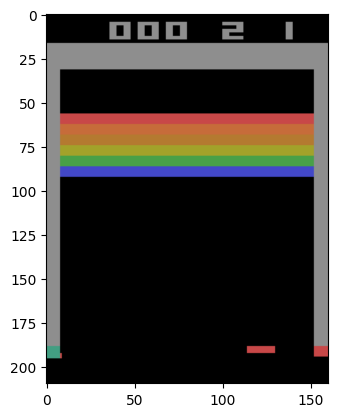

In [7]:
# Renders some sample frames within the Jupyter notebook. 
# It's not very fast!

import matplotlib.pyplot as plt
import gymnasium as gym
from IPython import display
%matplotlib inline

# Initialise the environment
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)

for step in range(100):
    # Render the environment  
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # Choose a random action, this is where we would insert a policy
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    
    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [8]:
# Renders some sample frames in a separate window. 
# Smoother than in inline rendering but closing the window resets the Jupyter notebook kernal

import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

# Initialise the environment
env = gym.make("ALE/Breakout-v5", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
for _ in range(1000):
    # Choose a random action, this is where we would insert a policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()